<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/Kaggle_Competition_Advanced_House_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data yang Digunakan

Di dalam lab satu ini, data yang akan kita gunakan merupakan salah satu data dari kompetisi Kaggle, yaitu <i>House Price - Advanced Regression Techniques</i>. Tujuan lab ini adalah untuk mengeksplore dan menerapkan beberapa teknik dan strategi dalam machine learning, seperti <i>KFold</i> dan <i>GridSearch</i>.

# Mendownload Data Secara Langsung Dari Kaggle

Terdapat beberapa cara untuk mengupload data ke dalam google colab. Tetapi, kita ingin melakukannya secara efisien. Oleh karena itu, sangatlah penting untuk memiliki pola kerja yang terstruktur dan terorganisir. Beruntungnya, setiap dataset yang berada di dalam kaggle memiliki API command yang dapat kita gunakan untuk mendownload dataset secara langsung di dalam shell. Untuk mendapatkan API Command dalam setiap kompetisi kaggle, hal yang harus dilakukan adalah <b>Masuk ke halaman kompetisi kaggle >> Data >> Scroll bawah >> Copy API Command</b>. Setelah kita mendapatkan API Command, kita dapat melakukan cara seperti di bawah:
- Masuk ke halaman kaggle (dengan anggapan kalian sudah memiliki akun kaggle).
- Klik bagian icon akun (ujung atas kanan) >> pilih account >> account >> Scroll bawah, cari tombol Create New API Token.
- Setelah API Token di download, buatlah folder baru di dalam google drive dan simpan kaggle.json yang telah di download. Jangan lupa untuk membuat link google drive menjadi publik.

Setelah kita melakukan persiapan, kita dapat langsung mendownload dataset dari kaggle. Kalian dapat menggunakan template yang berada di bawah ini untuk project yang lainnya.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%shell
cp '/content/gdrive/My Drive/KaggleAPI/kaggle.json' kaggle.json
pip install -q kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 101MB/s]


In [3]:
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action = 'ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


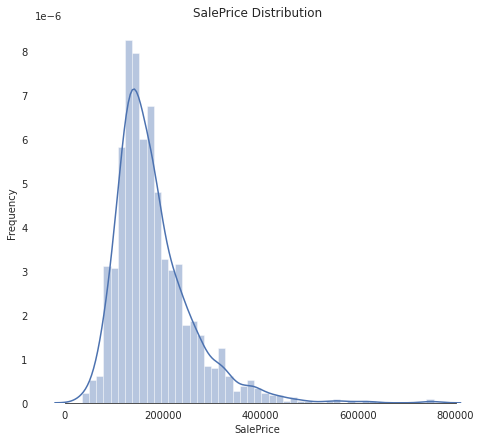

In [13]:
sns.set_style('white')
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (8, 7))

sns.distplot(train['SalePrice'], color = 'b')
ax.xaxis.grid(False)
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePrice Distribution')
sns.despine(trim = True, left = True)

In [15]:
print('Skewness: %f' % train['SalePrice'].skew())
print('Kurtosis: %f' % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


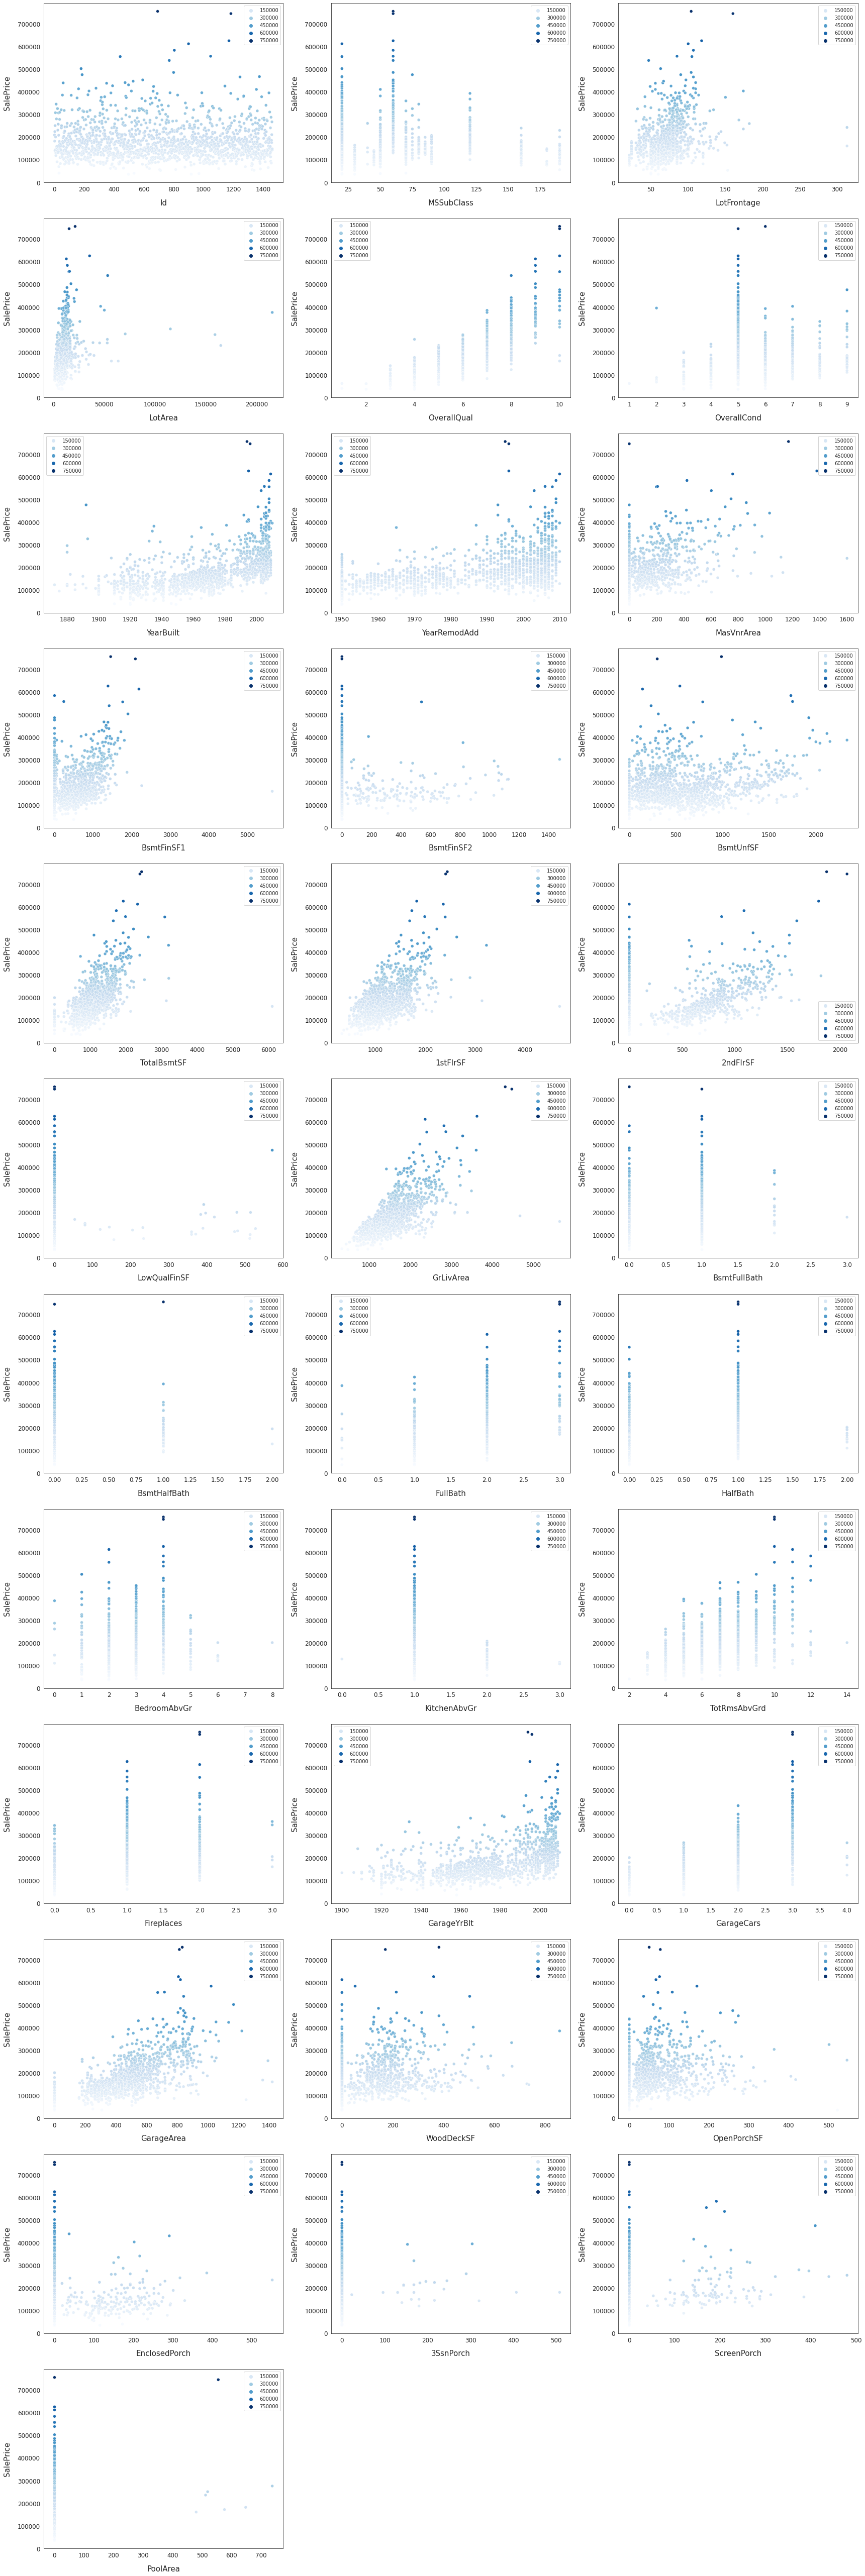

In [17]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
  if train[i].dtype in numeric_dtypes:
    if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
      pass
    else:
      numeric.append(i)

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 120))
plt.subplots_adjust(right = 2)
plt.subplots_adjust(top = 2)
sns.color_palette('husl', 8)
for i, feature in enumerate(list(train[numeric]), 1):
  if feature == 'MiscVal':
    break
  plt.subplot(len(list(numeric)), 3, i)
  sns.scatterplot(x = feature, y = 'SalePrice', hue = 'SalePrice', palette = 'Blues', data = train)

  plt.xlabel('{}'.format(feature), size = 15, labelpad = 12.5)
  plt.ylabel('SalePrice', size = 15, labelpad = 12.5)

  for _ in range(2):
    plt.tick_params(axis = 'x', labelsize = 12)
    plt.tick_params(axis = 'y', labelsize = 12)

  plt.legend(loc = 'best', prop = {'size' : 10})

<AxesSubplot:>

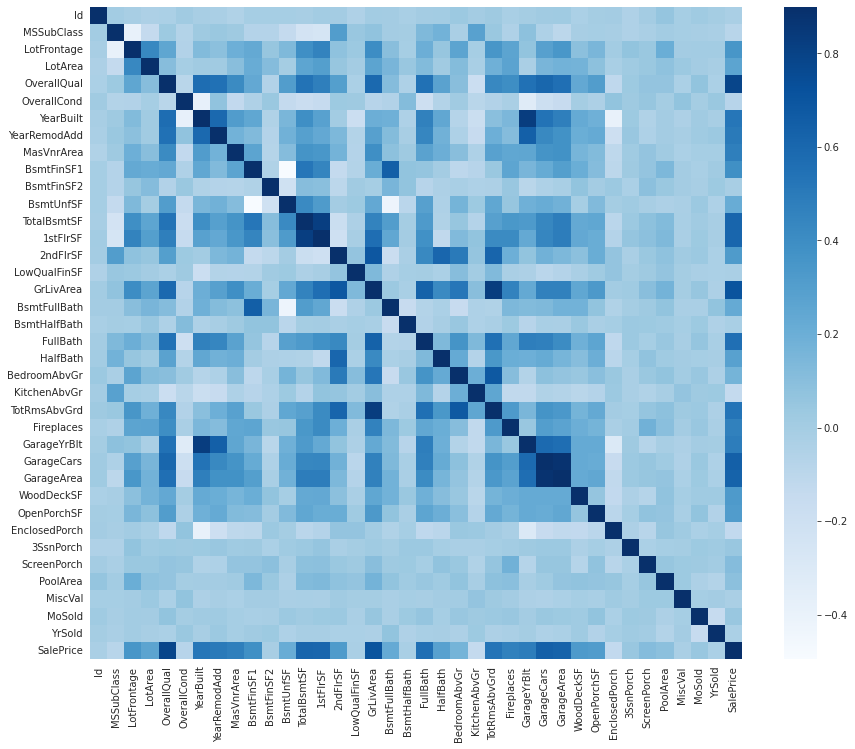

In [19]:
corr = train.corr()
plt.subplots(figsize = (15, 12))
sns.heatmap(corr, vmax = 0.9, cmap = 'Blues', square = True)

(-0.5, 9.5, 0.0, 800000.0)

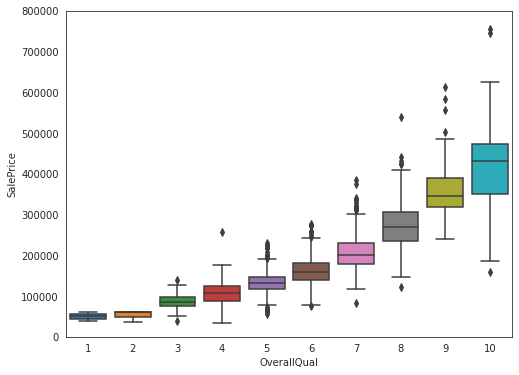

In [20]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x = train['OverallQual'], y = 'SalePrice', data = data)
fig.axis(ymin = 0, ymax = 800000)

In [21]:
train_ID = train['Id']
test_ID = test['Id']
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)
train.shape, test.shape

((1460, 80), (1459, 79))

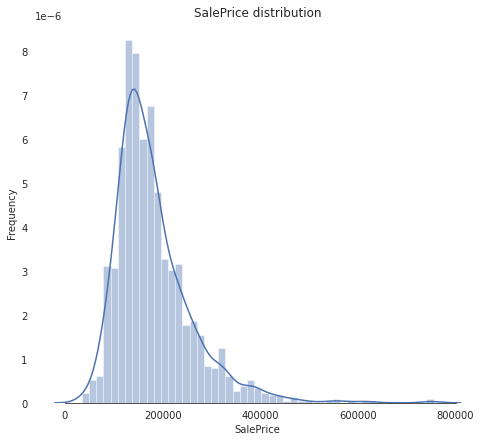

In [22]:
sns.set_style('white')
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (8, 7))

sns.distplot(train['SalePrice'], color = 'b')
ax.xaxis.grid(False)
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePrice distribution')
sns.despine(trim = True, left = True)

In [23]:
train['SalePrice'] = np.log1p(train['SalePrice'])


 mu = 12.02 and sigma = 0.40


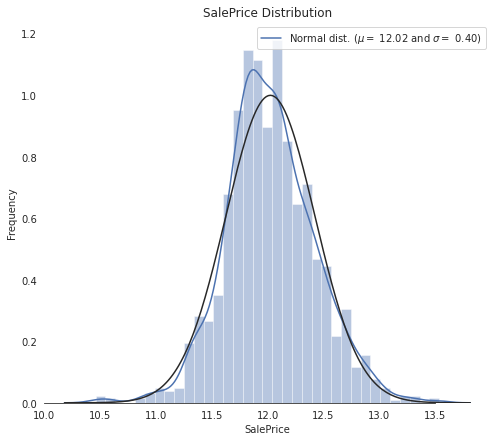

In [24]:
sns.set_style('white')
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (8, 7))
sns.distplot(train['SalePrice'], fit = norm, color = 'b')

(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu = $ {:.2f} and $\sigma = $ {:.2f})'.format(mu, sigma)], loc = 'best')
ax.xaxis.grid(False)
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePrice Distribution')
sns.despine(trim = True, left = True)

In [32]:
train.drop(train[(train['OverallQual'] < 5) & (train['SalePrice'] > 200000)].index, inplace = True)
train.drop(train[(train['GrLivArea'] > 4500) & (train['SalePrice'] < 300000)].index, inplace = True)
train.reset_index(drop = True, inplace = True)

In [33]:
train_labels = train['SalePrice'].reset_index(drop = True)
train_features = train.drop(['SalePrice'], axis = 1)
test_features = test

all_features = pd.concat([train_features, test_features]).reset_index(drop = True)
all_features.shape

(2917, 79)

In [34]:
def percent_missing(df):
  data = pd.DataFrame(df)
  df_cols = list(pd.DataFrame(df))
  dict_x = {}
  for i in range(0, len(df_cols)):
    dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean() * 100, 2)})

  return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key = lambda x: x[1], reverse = True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

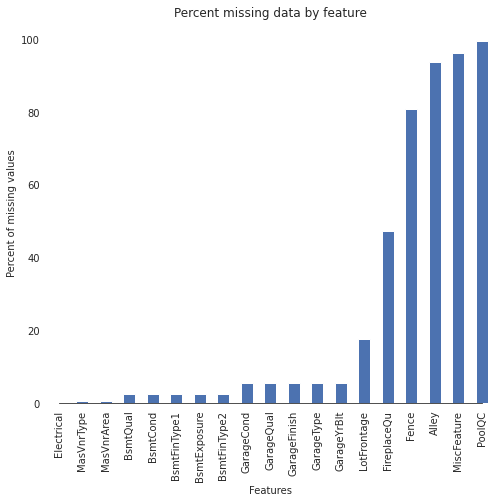

In [40]:
sns.set_style('white')
f, ax = plt.subplots(figsize = (8, 7))
sns.set_color_codes(palette = 'deep')
missing = round(train.isnull().mean() * 100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar(color = 'b')

ax.xaxis.grid(False)
ax.set(ylabel = 'Percent of missing values')
ax.set(xlabel = 'Features')
ax.set(title = 'Percent missing data by feature')
sns.despine(trim = True, left = True)

In [41]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)